In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [262]:
df = pd.read_csv(r'raw\fichajes_news.csv', sep=";")
df.head()

,title,date,content,whole
0,El Real Madrid lo tiene claro: negativa al AC ...,01/08,El Real Madrid ha rechazado un acercamiento po...,El Real Madrid lo tiene claro: negativa al AC ...
1,La Atalanta estudia moverse por una pieza de l...,01/08,Gian Piero Gasperini confía en potenciar toda...,La Atalanta estudia moverse por una pieza de l...
2,La Juventus estudia un fichaje de 20 M€,01/08,Decidida a mejorar las prestaciones de su ataq...,La Juventus estudia un fichaje de 20 M€ Decidi...
3,Osasuna confirma la venta de David García,01/08,Se venía apuntando a esta posibilidad desde h...,Osasuna confirma la venta de David García Se ...
4,El Atlético busca la fórmula para fichar a Al...,01/08,Aunque Alexander Sörloth ya ha dado el sí qui...,El Atlético busca la fórmula para fichar a Al...


In [263]:
def agregar_año(row):
    try:
        # Intentar convertir la fecha con el formato correcto, agregando el año apropiado
        fecha = pd.to_datetime(row['date'], format='%d/%m', errors='coerce')
        
        # Verificar si la fecha es válida (no es NaT)
        if pd.isna(fecha):
            return None  # Puedes decidir cómo manejar estas fechas no válidas
        
        # Lógica para asignar el año (ajusta según tus criterios)
        if fecha.month in range(10, 12+1):  
            return pd.to_datetime(row['date'] + '/2023', format='%d/%m/%Y', errors='coerce')
        else:  # De lo contrario, asignar 2024
            return pd.to_datetime(row['date'] + '/2024', format='%d/%m/%Y', errors='coerce')
    
    except Exception as e:
        print(f"Error procesando la fila {row.name}: {e}")
        return None
    

df['fecha_completa'] = df.apply(agregar_año, axis=1)
df.head()

,title,date,content,whole,fecha_completa
0,El Real Madrid lo tiene claro: negativa al AC ...,01/08,El Real Madrid ha rechazado un acercamiento po...,El Real Madrid lo tiene claro: negativa al AC ...,2024-08-01
1,La Atalanta estudia moverse por una pieza de l...,01/08,Gian Piero Gasperini confía en potenciar toda...,La Atalanta estudia moverse por una pieza de l...,2024-08-01
2,La Juventus estudia un fichaje de 20 M€,01/08,Decidida a mejorar las prestaciones de su ataq...,La Juventus estudia un fichaje de 20 M€ Decidi...,2024-08-01
3,Osasuna confirma la venta de David García,01/08,Se venía apuntando a esta posibilidad desde h...,Osasuna confirma la venta de David García Se ...,2024-08-01
4,El Atlético busca la fórmula para fichar a Al...,01/08,Aunque Alexander Sörloth ya ha dado el sí qui...,El Atlético busca la fórmula para fichar a Al...,2024-08-01


C:\Users\santi\AppData\Local\Temp\ipykernel_6172\1798059408.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_player.drop_duplicates(inplace=True)


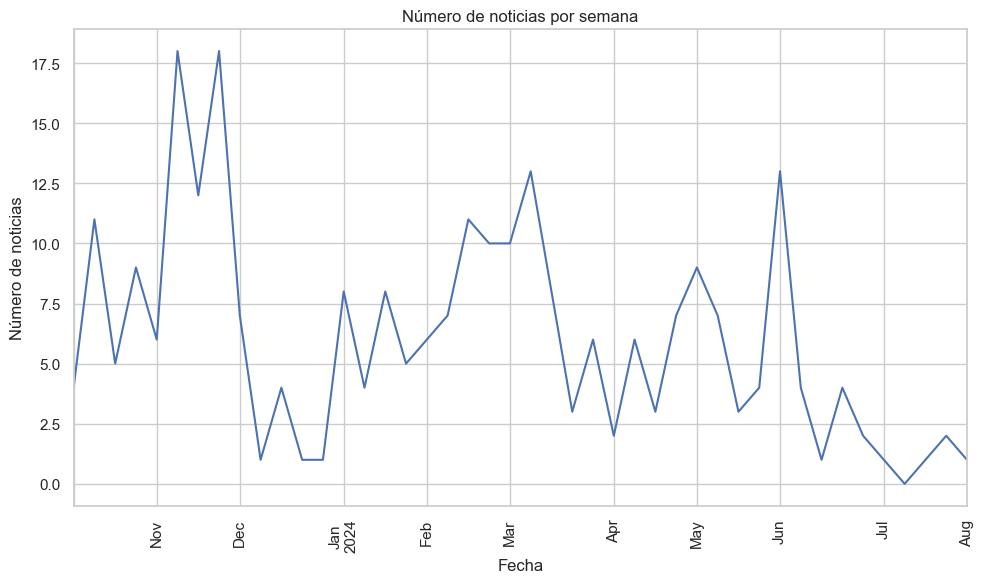

In [264]:
player = "Vinicius"

df_player = df[df['whole'].str.contains(player, case=False)]


df_player.drop_duplicates(inplace=True)


# Filtrar filas que no tengan fechas válidas
df_filtrado = df_player[df_player['fecha_completa'].notna()]

# 3. Contar cuántas noticias hay por día
noticias_por_dia = df_filtrado['fecha_completa'].value_counts().sort_index()



# 4. Crear un rango completo de fechas desde el 1 de enero de 2023 hasta el último día de noticias
fecha_inicio = pd.to_datetime('2023-10-04')
fecha_fin = pd.to_datetime('2024-08-01')  # Última fecha posible
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)

# 5. Crear un DataFrame con todas las fechas posibles y fusionarlo con el conteo de noticias
noticias_completas = pd.DataFrame(rango_fechas, columns=['fecha_completa']).set_index('fecha_completa')
noticias_completas['conteo'] = noticias_por_dia

# 6. Rellenar los días faltantes con 0
noticias_completas['conteo'] = noticias_completas['conteo'].fillna(0)

noticias_por_semana = noticias_completas['conteo'].resample('W').sum()



# 4. Graficar el resultado
plt.figure(figsize=(10,6))
noticias_por_semana.plot(kind='line')  # Puedes usar 'bar' si prefieres un gráfico de barras
plt.title('Número de noticias por semana')
plt.xlabel('Fecha')
plt.ylabel('Número de noticias')
plt.xticks(rotation=90)  # Para rotar las etiquetas de las fechas si es necesario
plt.tight_layout()  # Para ajustar el gráfico y que las etiquetas no se corten
plt.show()

In [265]:
def obtener_noticias(jugador, fecha_inicio, fecha_fin):
    df_player = df[df['whole'].str.contains(jugador, case=False)]
    df_player.drop_duplicates(inplace=True)

    df_player = df_player[
        (df_player['fecha_completa'] >= fecha_inicio) & 
        (df_player['fecha_completa'] <= fecha_fin)
    ]

    return df_player['whole'].to_list()

In [266]:
df_ratings = pd.read_csv(r'raw/players_unified_performance.csv')
final_df = df_ratings[['Player', 'Fecha', 'Normalized_performance']].copy()

final_df['Fecha'] = pd.to_datetime(final_df['Fecha'])

final_df = final_df.sort_values(by=['Player', 'Fecha'])


final_df['next_fecha'] = final_df.groupby('Player')['Fecha'].shift(-1)
final_df['next_performance'] = final_df.groupby('Player')['Normalized_performance'].shift(-1)

final_df = final_df.dropna(subset=['next_fecha', 'next_performance'])

final_df = final_df.rename(columns={
    'Fecha': "fecha1",
    'Normalized_performance': "performance1",
    'next_fecha': "fecha2",
    'next_performance': "performance2"
})



nombres_cambios = {
    "Ferran Torres": "Ferran",
    "Jules Koundé": "Koundé",
    "Vinicius Jr": "Vinicius",
}

final_df['Player'] = final_df['Player'].replace(nombres_cambios)



final_df["noticias"] = final_df.apply(lambda row: obtener_noticias(row['Player'], row['fecha1'], row['fecha2']), axis=1)


final_df

,Player,fecha1,performance1,fecha2,performance2,noticias
0,Ferran,2023-08-20,1.552046,2023-08-27,4.494561,[]
1,Ferran,2023-08-27,4.494561,2023-09-03,0.999954,[]
2,Ferran,2023-09-03,0.999954,2023-09-16,3.122298,[]
3,Ferran,2023-09-16,3.122298,2023-09-19,1.675618,[]
4,Ferran,2023-09-19,1.675618,2023-09-23,4.368031,[]
...,...,...,...,...,...,...
531,Vinicius,2024-05-08,7.199490,2024-05-14,9.322516,[¡El Real Madrid rechaza una oferta de 120 M€!...
532,Vinicius,2024-05-14,9.322516,2024-05-25,4.264257,[Liga | El Real Madrid despide a Toni Kroos en...
533,Vinicius,2024-05-25,4.264257,2024-06-01,6.860862,[Borussia Dortmund - Real Madrid | Las reaccio...
534,Vinicius,2024-06-01,6.860862,2024-06-24,3.282054,[El Liverpool espera su oportunidad para pesca...


In [276]:
# save to csv
final_df.to_csv('processed/data_processed.csv', index=False)

C:\Users\santi\AppData\Local\Temp\ipykernel_6172\440462586.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  futbol_jugador_df['num_noticias'] = futbol_jugador_df['noticias'].apply(len)


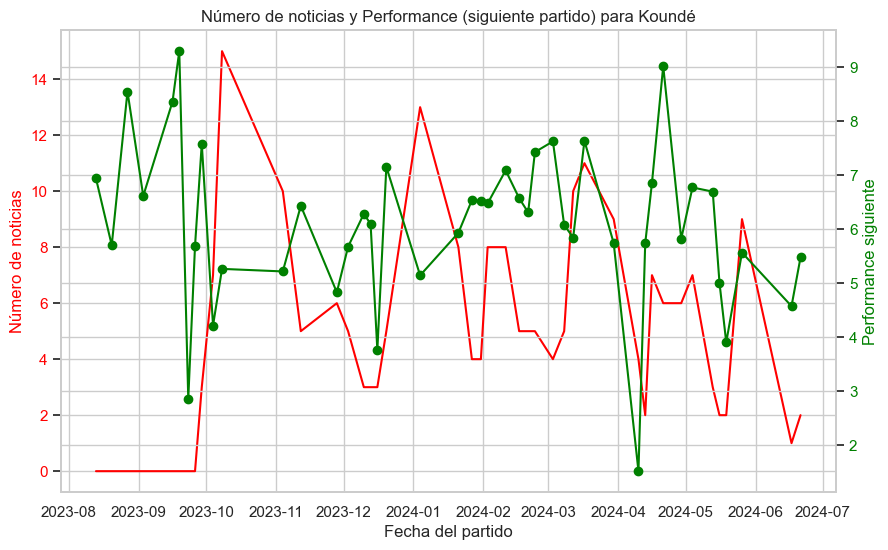

In [275]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


jugador = 'Koundé'
futbol_jugador_df = final_df[final_df['Player'] == jugador]

# Creamos una columna con el número de noticias por intervalo
futbol_jugador_df['num_noticias'] = futbol_jugador_df['noticias'].apply(len)

# Configuramos el estilo de seaborn para el plot
sns.set(style="whitegrid")

# Creamos la figura y el primer eje (el número de noticias)
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot del número de noticias en el eje izquierdo
ax1.plot(futbol_jugador_df['fecha1'], futbol_jugador_df['num_noticias'], color='red', label='Número de noticias')
ax1.set_xlabel('Fecha del partido')
ax1.set_ylabel('Número de noticias', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear el segundo eje (performance_siguiente o performance2) compartiendo el eje X
ax2 = ax1.twinx()
ax2.plot(futbol_jugador_df['fecha1'], futbol_jugador_df['performance2'], color='green', marker='o', label='Performance siguiente')
ax2.set_ylabel('Performance siguiente', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Ajustamos el título y mostramos el gráfico
plt.title(f'Número de noticias y Performance (siguiente partido) para {jugador}')
plt.show()


# PRUEBA SENTIMENT 

In [268]:
'''from transformers import pipeline

sentiment_analysis = pipeline("sentiment-analysis", 
                              model="nlptown/bert-base-multilingual-uncased-sentiment")

for index, row in df_player.iterrows():
    try:
        result = sentiment_analysis(row['content'])
        print(f"Análisis de sentimiento para la fila {index}: {result}")
    except Exception as e:
        print(f"Error procesando la fila {index}: {e}")'''

'from transformers import pipeline\n\nsentiment_analysis = pipeline("sentiment-analysis", \n                              model="nlptown/bert-base-multilingual-uncased-sentiment")\n\nfor index, row in df_player.iterrows():\n    try:\n        result = sentiment_analysis(row[\'content\'])\n        print(f"Análisis de sentimiento para la fila {index}: {result}")\n    except Exception as e:\n        print(f"Error procesando la fila {index}: {e}")'